<a href="https://colab.research.google.com/github/dominikklepl/Neural-Networks-Intracranial-hemorrhage-detection/blob/master/03_Channel_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Models with CTs processed with 3 windows
In this notebook I will build neural networks using the images with three windows (bone, brain and subdural) that are saved in color channels.

## Setup and paths to data

Import all required packages

In [56]:
#connect google drive
from google.colab import drive

#dealing with zip
import zipfile

#importing labels and working with dataframe
import pandas as pd

#manipulation with images
import numpy as np
import imageio as iio
from math import ceil, floor, log
import cv2

#models
%tensorflow_version 1.x
import keras.utils
import tensorflow as tf
print(tf.__version__)
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

#pretrained models
from keras_applications.resnet import ResNet50
from keras_applications.inception_v3 import InceptionV3

#plotting
import matplotlib.pyplot as plt

1.15.0


In [58]:
InceptionV3

<function function.__sizeof__>

Check that GPU is available and that keras can use it.

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Connect Google Drive. That's where my data is stored.

In [3]:
GDRIVE_PATH = "/gdrive"
drive.mount(GDRIVE_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


Set paths to all required data

In [4]:
WORK_DIR = "/content/"
BASE_DIR = GDRIVE_PATH + "/My Drive/RSNA-comp/"
ZIP_PATH = BASE_DIR + "channels_proto.zip"
TRAIN_PATH = BASE_DIR + "train_proto.csv"
MODEL_PATH = BASE_DIR + "models" #for saving learned weights
RESULT_PATH = BASE_DIR + "results" #for saving performance of models
IMAGES_PATH = WORK_DIR + "images"

#if the model and results aren't created already, create them
!mkdir /gdrive/My\ Drive/RSNA-comp/models
!mkdir /gdrive/My\ Drive/RSNA-comp/results

#also create temporary folder in working directory for unzipping images
!mkdir /content/images

mkdir: cannot create directory ‘/gdrive/My Drive/RSNA-comp/models’: File exists
mkdir: cannot create directory ‘/gdrive/My Drive/RSNA-comp/results’: File exists


Images are saved in a zip file. For easier and faster manipulation, let's extract them to a folder in the working directory that we created before ("/content/images")

In [0]:
img_archive = zipfile.ZipFile(ZIP_PATH)
img_archive.extractall(path=IMAGES_PATH)

Load the csv with labels and metadata

In [41]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.sample(3)

,Unnamed: 0,level_0,Unnamed: 0.1,index,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,fname,MultiImagePositionPatient,ImagePositionPatient1,ImagePositionPatient2,MultiImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,pct_cut
277,277,71898,71898,499033,ID_0e5716c33,CT,ID_11744b2c,ID_6497356813,ID_a734a71007,NaN,-112.000000,1.0,1,MONOCHROME2,512,512,0.437500,16,12,11,0,36.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detectio...,1,14.000000,188.799988,1,0.0,0.0,0.0,1.0,0.0,1,0.437500,0,2564,631.997086,548.921283,0.355259,1.0,36.0,1.0,80.0,1,1,1,0,0,0,"(0.3, 1.0]"
928,928,97243,97243,381391,ID_07b87de92,CT,ID_420de0ca,ID_429a9cfdbf,ID_32a38fb887,NaN,-115.500000,1.0,1,MONOCHROME2,512,512,0.451172,16,12,11,0,36.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detectio...,1,-1.500000,136.400024,1,0.0,0.0,0.0,1.0,0.0,1,0.451172,2,2474,561.793259,586.651967,0.319126,1.0,36.0,1.0,80.0,0,0,0,0,0,0,"(0.3, 1.0]"
179,179,56125,56125,388637,ID_8474d3086,CT,ID_ae5b7aa1,ID_3f1a36d6be,ID_9e764aa2ba,NaN,-126.408875,1.0,1,MONOCHROME2,512,512,0.494751,16,16,15,1,35.0,135.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detectio...,1,-126.408875,112.744804,1,0.0,0.0,0.0,1.0,0.0,1,0.494751,0,2860,465.113483,567.325815,0.221146,NaN,NaN,NaN,NaN,1,0,0,0,1,0,"(0.2, 0.3]"


Some of the columns are useless at this point, let's keep just those that we actually need. Also some of the columns have too long name, yes SOPInstanceUID I'm talking about you so we'll rename them.

In [50]:
train = train_df[['SOPInstanceUID',
                  'PatientID',
                  'any',
                  'epidural',
                  'intraparenchymal',
                  'intraventricular',
                  'subarachnoid',
                  'subdural']].copy()
train.rename(columns={'SOPInstanceUID': 'ID',
                      'PatientID': 'Patient'},
              inplace=True)
train.head(5)

,ID,Patient,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_1e3b6bd54,ID_139ecbbf,1,0,1,1,0,0
1,ID_069fe65a8,ID_ac4691db,1,0,0,1,0,0
2,ID_6e4410d09,ID_3d4f7d62,1,0,0,0,0,1
3,ID_50cdcac76,ID_010f1536,1,0,0,0,1,0
4,ID_1cfbbc596,ID_0463ca7e,1,0,0,0,0,1


## Data processing functions
Before we can start building awesome neural networks, we need a few helper functions for constructing data (i.e. images) in form that's acceptable for the models to learn from.

First, a function for loading a single image and resizing it to the input size.

In [0]:
def read_img(ID, resize):
    filename = IMAGES_PATH+'/'+ID+'.png'
    img = iio.imread(filename)
    img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_CUBIC) #resize
    img = (img - np.min(img))/(np.max(img)-np.min(img)) #min-max normalize
    return img

CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 14 ms
<class 'numpy.ndarray'>
0.0
1.0


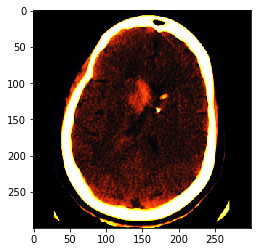

In [25]:
%time img = read_img(train.ID[0], (300, 300, 3))

#some sanity checks
print(type(img))
plt.imshow(img)

print(np.min(img))
print(np.max(img))

### Data generator
This function prepares each batch for feeding to neural network. First, it gets random IDs and associated labels. Then shuffles them, to reduce bias. Finally, the images, using the IDs are loaded using the _read function defined above.

The function is generalized for both training and testing data.

It is derived from keras.sequence so it should be enabled for multiprocessing.

In [0]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, IDs, labels=None, batch_size=30, img_size=(512, 512, 3), num_classes=5, *args, **kwargs):
        self.IDs = IDs
        self.labels = labels.loc[:, 'any':'subdural']
        self.batch_size = batch_size
        self.img_size = img_size
        self.on_epoch_end()

#define number of steps per epoch
    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        IDs_batch = [self.IDs[k] for k in indices]
        if self.labels is not None:
          X, y_any, y_subtype = self.__data_generation(current_ids)
          return X, [y_any, y_subtype]
        else:
            X = self.__data_generation(IDs_batch)
            return X
        
    def on_epoch_end(self):
        if self.labels is not None: #during training we shuffle the images
            self.indices = np.arange(len(self.IDs))
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.IDs))

    def __data_generation(self, IDs_batch):
        X = np.empty((self.batch_size, *self.img_size))
        if self.labels is not None: # training
          y_subtype = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
          y_any = np.empty((self.batch_size, 1), dtype=np.float32)
          for i, ID in enumerate(IDs_batch):
            X[i,] = read_img(ID, self.img_size)
            Y[i,] = self.labels.loc[ID].values
            y_any[i], y_subtype[i] = self.__get_target(ID)
            return X, y_subtype, y_any
        else: # testing
            for i, ID in enumerate(IDs_batch):
                X[i,] = read_img(ID, self.img_size)
            return X

    def __get_target(self, ID):
        y_any = self.labels.loc[ID, "any"]
        y_subtype = self.labels.drop("any", axis=1).loc[ID].values
        return y_any, y_subtype

### Getting predictions after each epoch

In [0]:
class PredictionCheckpoint(keras.callbacks.Callback):
    
    def __init__(self, valid_df,
                 batch_size=32, input_size=(224, 224, 3)):

        self.valid_df = valid_df
        self.batch_size = batch_size
        self.input_size = input_size
        
    def on_train_begin(self, logs={}):
        self.valid_predictions = []
        
    def on_epoch_end(self,batch, logs={}):
         self.valid_predictions.append(
             self.model.predict_generator(
                 DataGenerator(self.valid_df.ID, None, self.batch_size, self.input_size), verbose=2)[:len(self.valid_df)])
        
         print("validation loss: %.4f" %
               weighted_log_loss_metric(self.valid_df.values, 
                                    np.average(self.valid_predictions, axis=0, 
                                               weights=[2**i for i in range(len(self.valid_predictions))])))

## Loss functions and performance metrics

### Multilabel Loss

In [0]:
def np_multilabel_loss(y_true, y_pred, class_weights=np.array([2., 1., 1., 1., 1., 1.])):
    y_pred = np.where(y_pred > 1-(1e-07), 1-1e-07, y_pred)
    y_pred = np.where(y_pred < 1e-07, 1e-07, y_pred)
    single_class_cross_entropies = - np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred), axis=0)
    
    print(single_class_cross_entropies)
    if class_weights is None:
        loss = np.mean(single_class_cross_entropies)
    else:
        loss = np.sum(class_weights*single_class_cross_entropies)
    return loss

### Performance metrics

In [0]:
#F1 score

## Transfer learning model

In [0]:
class Transfer_network:
    
    def __init__(self, engine, loss_fun, metrics_list, input_dims, train_generator, val_generator,
                 epochs, learning_rate=1e-3, num_classes=5, checkpoint_path=MODEL_PATH):
        
        self.loss_fun = loss_fun
        self.metrics_list = metrics_list
        self.input_dims = input_dims
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.checkpoint_path = checkpoint_path 

        #args for saving trained weights at the epoch with best validation loss
        self.checkpoint = ModelCheckpoint(filepath=self.checkpoint_path,
                                          mode="min",
                                          verbose=1,
                                          save_best_only=True,
                                          save_weights_only=True,
                                          period=1)
        
        #when loss stops decresing, decrease learning rate
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.5,
                                           patience=2,
                                           min_lr=1e-8,
                                           mode="min")
        

        self.e_stopping = EarlyStopping(monitor="val_loss",
                                        min_delta=0.01,
                                        patience=5,
                                        mode="min",
                                        restore_best_weights=True)
        
    def build_model(self):
        transfer = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,
                             backend = keras.backend, layers = keras.layers,
                             models = keras.models, utils = keras.utils)
        x = transfer.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.3)(x)
        x = Dense(100, activation="relu")(x)
        x = Dropout(0.3)(x)
        any_logits = Dense(1, kernel_initializer=he_normal(seed=11))(x)
        any_pred = Activation("sigmoid", name="any_predictions")(any_logits)
        x = concatenate([any_pred, x])
        sub_pred = Dense(self.num_classes,
                         name="subtype_pred",
                         kernel_initializer=he_normal(seed=12),
                         activation="sigmoid")(x) 
        self.model = Model(inputs=transfer.input, outputs=[any_pred, sub_pred])
    
    def compile_model(self):
      self.model.compile(optimizer=Adam(learning_rate),
                         loss=['binary_crossentropy', np_multilabel_loss],
                         loss_weights = [1., 0.],
                         metrics=self.metrics_list)
    
    def learn(self):
        return self.model.fit_generator(generator=self.train_generator,
                    validation_data=self.val_generator,
                    epochs=self.epochs,
                    callbacks=[self.checkpoint, self.reduce_lr, self.e_stopping],
                    use_multiprocessing=True,
                    workers=8)
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def predict(self, data_generator):
        predictions = self.model.predict_generator(data_generator, workers=8)
        return predictions

## 